# How to find industry 101

In [205]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import math
import unicodedata
from itertools import combinations


def clean_firm_name(x: str):
    """Approximate R's iconv(to='ASCII//TRANSLIT') + trimws + NA handling."""
    if pd.isna(x):
        return None
    x = str(x).strip()
    x = unicodedata.normalize("NFKD", x).encode("ascii", "ignore").decode("ascii")
    x = x.strip()
    return x or None


def plot_focal_industry_network(
    df: pd.DataFrame,
    sic_primary_code,
    continent,
    figsize=(9, 7),
    min_degree=0,
    include_non_focal=True,
    plot=False,
):
    """
    Plot a firm–firm strategic alliance network for a given focal industry×region.
    """

    df_local = df.copy()

    # --- 1. Clean participants & firm names ---
    df_local["participants"] = (
        df_local["participants"]
        .astype(str)
        .str.strip()
        .replace({"": pd.NA, "NA": pd.NA, "<NA>": pd.NA})
    )
    df_local["firm"] = df_local["participants"].apply(clean_firm_name)
    df_local = df_local[df_local["firm"].notna()].copy()

    # --- 2. Filter to completed, signed strategic alliances ---
    mask_core = (
        (df_local["status"] == "Completed/Signed")
        & (df_local["type"] == "Strategic Alliance")
    )
    df_local = df_local.loc[mask_core].copy()

    # Ensure sic_primary numeric for comparison
    df_local["sic_primary"] = pd.to_numeric(df_local["sic_primary"], errors="coerce")

    # --- 3. Identify focal firms (industry × region) ---
    focal_mask = (
        (df_local["sic_primary"] == sic_primary_code)
        & (df_local["continent"] == continent)
    )
    focal_firms = set(df_local.loc[focal_mask, "firm"].unique())

    if not focal_firms:
        print(f"No focal firms found for SIC {sic_primary_code} in {continent}.")
        return None, set()

    # --- 4. Find all deals involving at least one focal firm ---
    deals_with_focal = df_local[df_local["firm"].isin(focal_firms)]["deal_number"].unique()

    if len(deals_with_focal) == 0:
        print(f"No deals involving focal firms for SIC {sic_primary_code} in {continent}.")
        return None, focal_firms

    df_deals = df_local[df_local["deal_number"].isin(deals_with_focal)].copy()

    # If we exclude non-focal firms, drop them here
    if not include_non_focal:
        df_deals = df_deals[df_deals["firm"].isin(focal_firms)].copy()

    # --- 5. Build firm–firm edges from co-participation in those deals ---
    edges = []
    for deal_id, group in df_deals.groupby("deal_number"):
        firms = sorted(group["firm"].unique())
        if len(firms) < 2:
            continue
        for a, b in combinations(firms, 2):
            if a != b:
                edges.append((a, b))

    if not edges:
        print(
            f"No multi-participant deals for SIC {sic_primary_code} in {continent} "
            f"(include_non_focal={include_non_focal})."
        )
        return None, focal_firms

    G = nx.Graph()
    G.add_edges_from(edges)

    # --- 6. Optionally prune very low-degree nodes ---
    if min_degree > 1:
        to_remove = [n for n, d in G.degree() if d < min_degree]
        G.remove_nodes_from(to_remove)

    if G.number_of_nodes() == 0:
        print("Graph is empty after applying min_degree filter.")
        return None, focal_firms


    # --- 6c. Number of connected components in the plotted graph ---
    n_components = nx.number_connected_components(G)


    if not plot:
        return G, focal_firms, n_components
    # --- 7. Plot with denser layout & clearer styling ---
    plt.figure(figsize=figsize)

    n_nodes = G.number_of_nodes()
    base_k = 1.0 / math.sqrt(n_nodes)
    k = base_k * 5  # tweak as desired

    pos = nx.spring_layout(
        G,
        seed=42,
        k=k,
        iterations=150,
        scale=1.0
    )

    degrees = dict(G.degree())
    node_sizes = [40 + 15 * math.sqrt(degrees[n]) for n in G.nodes()]

    node_colors = [
        "tab:red" if n in focal_firms else "lightgray"
        for n in G.nodes()
    ]

    nx.draw_networkx_edges(
        G,
        pos,
        width=0.8,
        alpha=0.4,
        edge_color="white",
    )

    nx.draw_networkx_nodes(
        G,
        pos,
        node_size=node_sizes,
        node_color=node_colors,
        alpha=0.95,
        linewidths=0.5,
        edgecolors="black",
    )

    plt.axis("off")
    plt.title(
        f"Strategic Alliances Network\n"
        f"Focal SIC={sic_primary_code} ({len(focal_firms)}), Continent={continent} | "
        f"Nodes: {G.number_of_nodes()} | Edges: {G.number_of_edges()} | "
        f"CCs: {n_components}\n"
        f"Focal firms (red); partners (gray); include_non_focal={include_non_focal}"
    )
    plt.tight_layout()
    plt.show()

    return G, focal_firms, n_components


In [193]:
import pyreadr
import pandas as pd
from itertools import combinations
import country_converter as coco
import numpy as np
from tqdm.auto import tqdm
import unicodedata
import warnings
warnings.filterwarnings("ignore")

# =========================
# 0. Load SDC & clean names
# =========================

result = pyreadr.read_r('../raw_downloads/SDC_data_2021.rds')
sdc = list(result.values())[0]  # SDC data frame

country_fix_map = {
    "Utd Arab Em": "United Arab Emirates",
    "C. African Rep": "Central African Republic",
    "Unknown": pd.NA,
    "unknown": pd.NA,
    "UNKNOWN": pd.NA,
    "Soviet Union": pd.NA,
    "Yugoslavia": pd.NA,
    "East Germany": "Germany",
    "Neth Antilles": pd.NA,
    "Netherlands Antilles": pd.NA,
    "Supranational": pd.NA,
    "<NA>": pd.NA,
}

# mimic janitor::clean_names()
sdc.columns = (
    sdc.columns
      .str.strip()
      .str.lower()
)

required_cols = {
    "participants", "sic_primary", "participant_nation",
    "status", "type", "deal_number", "date_announced"
}
missing = required_cols - set(sdc.columns)
if missing:
    raise ValueError(f"Missing required columns in SDC data: {missing}")

# ====================================
# 1. Clean & filter strategic alliances
# ====================================

sdc["participants"] = (
    sdc["participants"]
    .astype(str)
    .str.strip()
    .replace({"": pd.NA, "NA": pd.NA, "<NA>": pd.NA})
)

mask = (sdc["status"] == "Completed/Signed") & (sdc["type"] == "Strategic Alliance")
sdc_filt = sdc.loc[mask].copy()
sdc_filt = sdc_filt[sdc_filt["participants"].notna()].copy()

sdc_filt["participant_nation"] = (
    sdc_filt["participant_nation"]
    .astype(str)
    .str.strip()
    .replace(country_fix_map)
)

def clean_firm_name(x):
    if pd.isna(x):
        return pd.NA
    x = str(x).strip()
    x = unicodedata.normalize("NFKD", x).encode("ascii", "ignore").decode("ascii")
    x = x.strip()
    return x if x else pd.NA

sdc_filt["firm"] = sdc_filt["participants"].apply(clean_firm_name)
sdc_filt = sdc_filt[sdc_filt["firm"].notna()].copy()

# Map participant_nation → continent
cc = coco.CountryConverter()
sdc_filt["continent"] = cc.convert(
    names=sdc_filt["participant_nation"],
    to="continent",
    not_found="not found"
)
sdc_filt.loc[sdc_filt["continent"] == "not found", "continent"] = pd.NA

# =====================================
# 2. Build global co-alliance network
# =====================================

edges = []
for deal_id, group in tqdm(sdc_filt.groupby("deal_number")):
    firms = sorted(group["firm"].unique())
    if len(firms) < 2:
        continue
    for a, b in combinations(firms, 2):
        if a != b:
            edges.append((a, b))

edges_df = pd.DataFrame(edges, columns=["from_firm", "to_firm"]).drop_duplicates()
if edges_df.empty:
    raise ValueError("No edges found after filtering; check your data and filters.")

deg_from = edges_df.groupby("from_firm").size()
deg_to = edges_df.groupby("to_firm").size()
deg_series = deg_from.add(deg_to, fill_value=0).astype(int)

degree_df = (
    deg_series
    .rename("degree")
    .reset_index()
    .rename(columns={"index": "firm"})
)

firm_info = (
    sdc_filt[["firm", "sic_primary", "continent"]]
    .drop_duplicates()
)

degree_with_meta = degree_df.merge(firm_info, on="firm", how="left")

degree_with_sic = degree_with_meta.dropna(subset=["sic_primary"]).copy()
degree_with_sic["sic_primary"] = pd.to_numeric(degree_with_sic["sic_primary"], errors="coerce")

# =====================================================
# 3. Global industry-level metrics (rough context)
# =====================================================

sic_basic = (
    sdc_filt.dropna(subset=["sic_primary"])
    .assign(sic_primary=lambda df: pd.to_numeric(df["sic_primary"], errors="coerce"))
)

sic_basic_stats = (
    sic_basic.groupby("sic_primary")
    .agg(
        n_firms=("firm", lambda x: x.nunique()),
        n_deals=("deal_number", "nunique"),
        n_continents=("continent", lambda x: x.dropna().nunique()),
        min_year=("date_announced", lambda x: pd.to_datetime(x, errors="coerce").min()),
        max_year=("date_announced", lambda x: pd.to_datetime(x, errors="coerce").max()),
    )
    .reset_index()
)

sic_degree_stats = (
    degree_with_sic.groupby("sic_primary")["degree"]
    .agg(
        mean_degree="mean",
        median_degree="median",
        max_degree="max",
        n_firms_degree="count"
    )
    .reset_index()
)

sic_stats_full = sic_basic_stats.merge(
    sic_degree_stats,
    on="sic_primary",
    how="left"
)

sic_stats_full[["mean_degree", "median_degree", "max_degree"]] = sic_stats_full[
    ["mean_degree", "median_degree", "max_degree"]
].fillna(0)

# =====================================================
# 4. Deal-level cross-continental info
# =====================================================

deal_stats = (
    sdc_filt.groupby("deal_number")
    .agg(
        n_firms=("firm", "nunique"),
        n_continents=("continent", lambda x: x.dropna().nunique())
    )
    .reset_index()
)
deal_stats["is_cross_continental"] = deal_stats["n_continents"] > 1

# =====================================================
# 5. Region × SIC metrics (including activity, richness, variability)
# =====================================================

deg_sic_region = degree_with_sic.dropna(subset=["continent"]).copy()

rows = []

for (sic, cont), group in tqdm(deg_sic_region.groupby(["sic_primary", "continent"])):
    focal_firms = group["firm"].unique()
    n_focal_firms = len(focal_firms)

    # degree stats for focal firms (in global network)
    mean_deg = group["degree"].mean()
    median_deg = group["degree"].median()
    max_deg = group["degree"].max()
    degree_std = group["degree"].std(ddof=0) if n_focal_firms > 1 else 0.0
    if mean_deg and mean_deg != 0:
        degree_cv = degree_std / mean_deg
    else:
        degree_cv = 0.0

    # deals where at least one focal firm participates
    deals_for_focal = sdc_filt[sdc_filt["firm"].isin(focal_firms)]["deal_number"].unique()
    n_focal_deals = len(deals_for_focal)

    if n_focal_deals > 0:
        ds = deal_stats[deal_stats["deal_number"].isin(deals_for_focal)]
        n_cross = int(ds["is_cross_continental"].sum())
        cross_share = n_cross / n_focal_deals
    else:
        n_cross = 0
        cross_share = 0.0

    # --- Alliance activity: alliances per focal firm ---
    alliances_per_firm = n_focal_deals / n_focal_firms if n_focal_firms > 0 else 0.0

    # --- Network richness: portfolio network (focal + all partners) ---
    # all SA rows from deals where at least one focal firm participates
    df_portfolio = sdc_filt[sdc_filt["deal_number"].isin(deals_for_focal)].copy()
    network_firms = df_portfolio["firm"].unique()
    network_n_firms = len(network_firms)

    # build edges just for this portfolio network
    net_edges = set()
    for d_id, g_d in df_portfolio.groupby("deal_number"):
        firms_d = sorted(g_d["firm"].unique())
        if len(firms_d) < 2:
            continue
        for a, b in combinations(firms_d, 2):
            if a != b:
                # undirected edge as sorted tuple
                net_edges.add(tuple(sorted((a, b))))

    network_n_edges = len(net_edges)
    if network_n_firms > 0:
        network_mean_degree = (2.0 * network_n_edges) / network_n_firms
    else:
        network_mean_degree = 0.0

    if network_n_firms > 1:
        network_density = (2.0 * network_n_edges) / (network_n_firms * (network_n_firms - 1))
    else:
        network_density = 0.0

    rows.append({
        "sic_primary": sic,
        "continent": cont,
        "n_focal_firms": n_focal_firms,
        "n_focal_deals": n_focal_deals,
        "mean_degree": mean_deg,
        "median_degree": median_deg,
        "max_degree": max_deg,
        "degree_std": degree_std,
        "degree_cv": degree_cv,
        "n_cross_cont_deals": n_cross,
        "cross_cont_share": cross_share,
        # alliance activity
        "alliances_per_firm": alliances_per_firm,
        # portfolio network richness
        "network_n_firms": network_n_firms,
        "network_n_edges": network_n_edges,
        "network_mean_degree": network_mean_degree,
        "network_density": network_density,
    })

sic_region_stats = pd.DataFrame(rows)
if sic_region_stats.empty:
    raise ValueError("No SIC×region cells found – check data and filters.")

# =====================================================
# 6. Region-specific "interestingness" index (normalised metrics)
# =====================================================

# base transforms
sic_region_stats["log_firms"] = np.log1p(sic_region_stats["n_focal_firms"])
sic_region_stats["log_deals"] = np.log1p(sic_region_stats["n_focal_deals"])

# list of metrics to normalise (z-scores)
metrics_to_norm = [
    "log_firms",
    "log_deals",
    "cross_cont_share",
    "median_degree",
    "alliances_per_firm",
    "network_mean_degree",
    "degree_cv",
]

for col in metrics_to_norm:
    col_mean = sic_region_stats[col].mean()
    col_std = sic_region_stats[col].std(ddof=0)
    if col_std and col_std > 0:
        sic_region_stats[f"z_{col}"] = (sic_region_stats[col] - col_mean) / col_std
    else:
        sic_region_stats[f"z_{col}"] = 0.0

# weights for each normalised metric
w_log_firms = 1.0
w_log_deals = 1.0
w_cross = 1.0
w_mean_deg = 1.0
w_activity = 1.0
w_net_rich = 1.0
w_var = 1.0

sic_region_stats["interestingness_region"] = (
    w_log_firms * sic_region_stats["z_log_firms"]
    + w_log_deals * sic_region_stats["z_log_deals"]
    + w_cross * sic_region_stats["z_cross_cont_share"]
    + w_mean_deg * sic_region_stats["z_mean_degree"]
    + w_activity * sic_region_stats["z_alliances_per_firm"]
    + w_net_rich * sic_region_stats["z_network_mean_degree"]
    + w_var * sic_region_stats["z_degree_cv"]
)

# Now you can sort to pick focal industries per region:
sic_region_stats_sorted = sic_region_stats.sort_values(
    "interestingness_region",
    ascending=False
)

print(
    sic_region_stats_sorted[
        [
            "sic_primary", "continent",
            "n_focal_firms", "n_focal_deals",
            "alliances_per_firm",
            "mean_degree", "degree_cv",
            "network_n_firms", "network_n_edges",
            "network_mean_degree",
            "cross_cont_share",
            "interestingness_region",
        ]
    ].head(20)
)


<NA> not found in regex
<NA> not found in regex
<NA> not found in regex
<NA> not found in regex
<NA> not found in regex
<NA> not found in regex
<NA> not found in regex
<NA> not found in regex
<NA> not found in regex
<NA> not found in regex
<NA> not found in regex
<NA> not found in regex
<NA> not found in regex
<NA> not found in regex
<NA> not found in regex
<NA> not found in regex
<NA> not found in regex
<NA> not found in regex
<NA> not found in regex
<NA> not found in regex
<NA> not found in regex
<NA> not found in regex
<NA> not found in regex
<NA> not found in regex
<NA> not found in regex
<NA> not found in regex
<NA> not found in regex
<NA> not found in regex
<NA> not found in regex
<NA> not found in regex
<NA> not found in regex
<NA> not found in regex
<NA> not found in regex
<NA> not found in regex
<NA> not found in regex
<NA> not found in regex
<NA> not found in regex
<NA> not found in regex
<NA> not found in regex
<NA> not found in regex
<NA> not found in regex
<NA> not found i

  0%|          | 0/94737 [00:00<?, ?it/s]

  0%|          | 0/3290 [00:00<?, ?it/s]

      sic_primary continent  n_focal_firms  n_focal_deals  alliances_per_firm  \
2010       4931.0      Asia              1            122          122.000000   
2689       6799.0      Asia            702           1906            2.715100   
1411       3571.0   America            407           3700            9.090909   
1536       3651.0      Asia             94            927            9.861702   
1663       3769.0    Europe              2             43           21.500000   
1172       3398.0    Europe              1              1            1.000000   
775        2732.0      Asia              2             39           19.500000   
1104       3316.0      Asia              9             71            7.888889   
735        2657.0   America              3              9            3.000000   
1424       3577.0      Asia            109            623            5.715596   
2122       5065.0    Europe             52            268            5.153846   
2812       7373.0      Asia 

In [196]:
sic_region_stats_sorted[
        [
            "sic_primary", "continent",
            "n_focal_firms", "n_focal_deals",
            "alliances_per_firm",
            "mean_degree", "degree_cv",
            "network_n_firms", "network_n_edges",
            "network_mean_degree",
            "cross_cont_share",
            "interestingness_region",
        ]
    ].query("n_focal_firms > 50 & n_focal_firms < 200")

,sic_primary,continent,n_focal_firms,n_focal_deals,alliances_per_firm,mean_degree,degree_cv,network_n_firms,network_n_edges,network_mean_degree,cross_cont_share,interestingness_region
1536,3651.0,Asia,94,927,9.861702,11.297872,3.096525,811,1639,4.041924,0.737864,21.705004
1424,3577.0,Asia,109,623,5.715596,6.366972,4.244750,661,1090,3.298033,0.712681,18.296572
2122,5065.0,Europe,52,268,5.153846,5.557692,4.836092,335,605,3.611940,0.667910,17.917386
1551,3663.0,Europe,106,462,4.358491,4.943396,4.769835,572,843,2.947552,0.720779,17.188143
1550,3663.0,Asia,139,449,3.230216,3.467626,4.838093,546,549,2.010989,0.708241,14.813051
...,...,...,...,...,...,...,...,...,...,...,...,...
3209,8999.0,America,71,84,1.183099,1.253521,0.563593,157,90,1.146497,0.154762,1.631633
3118,8611.0,America,75,90,1.200000,1.280000,0.469791,168,101,1.202381,0.100000,1.515425
2840,7381.0,America,62,71,1.145161,1.274194,0.584064,130,75,1.153846,0.084507,1.237115
2022,4941.0,America,54,54,1.000000,1.296296,0.484031,102,62,1.215686,0.148148,1.041640


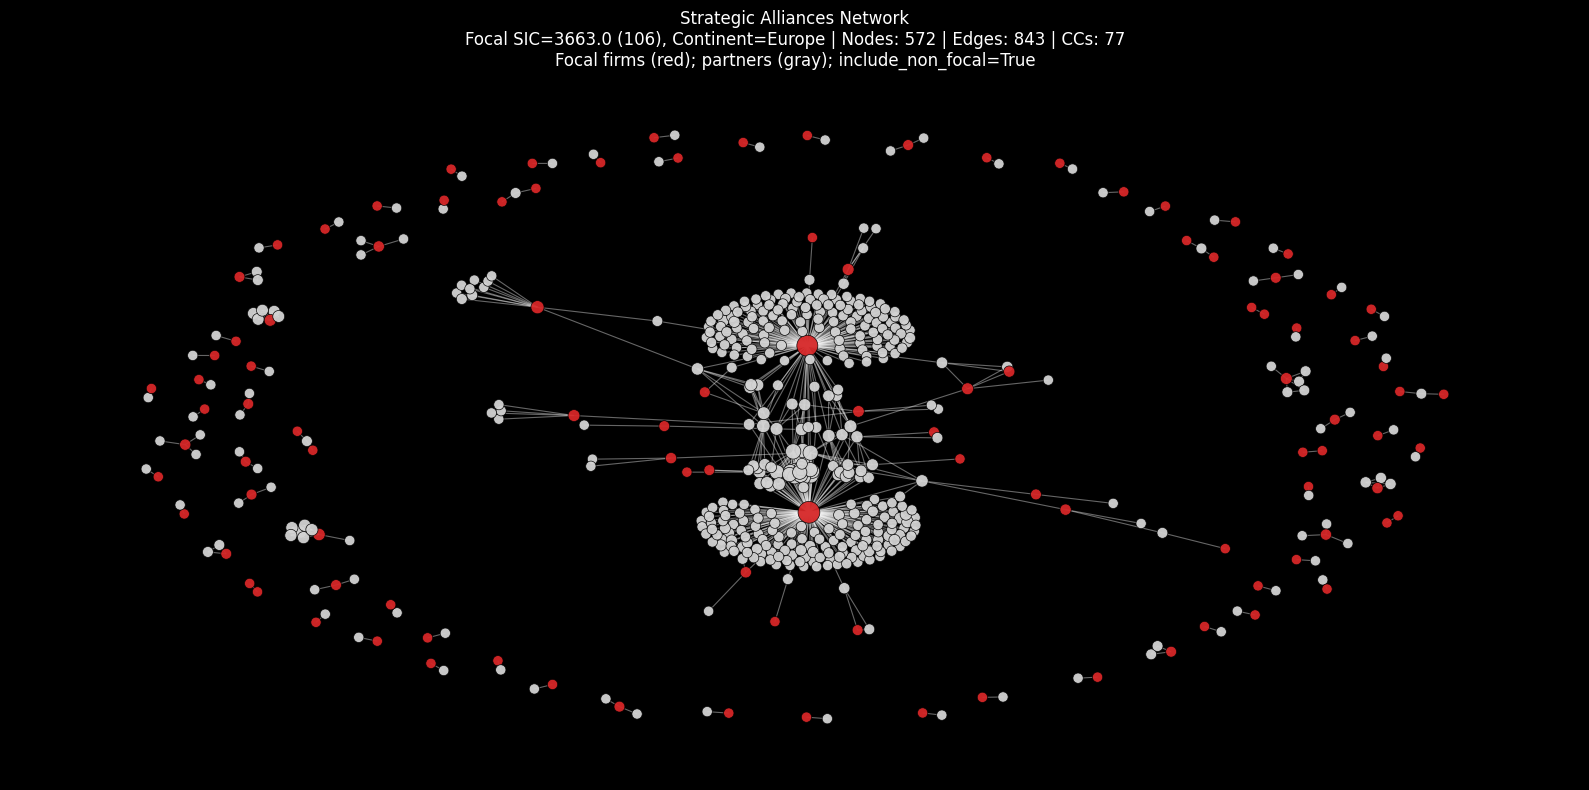

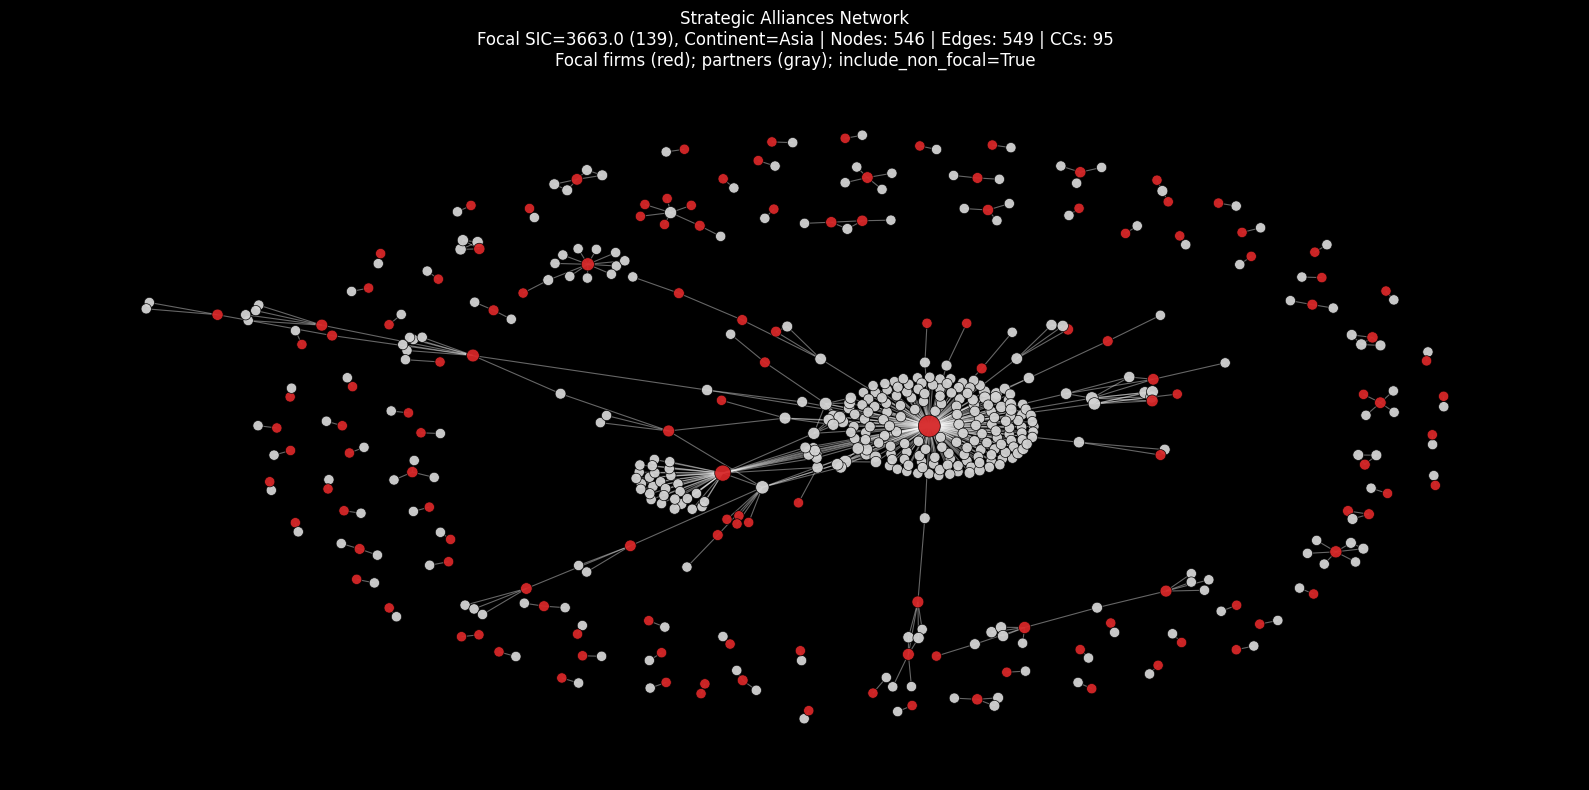

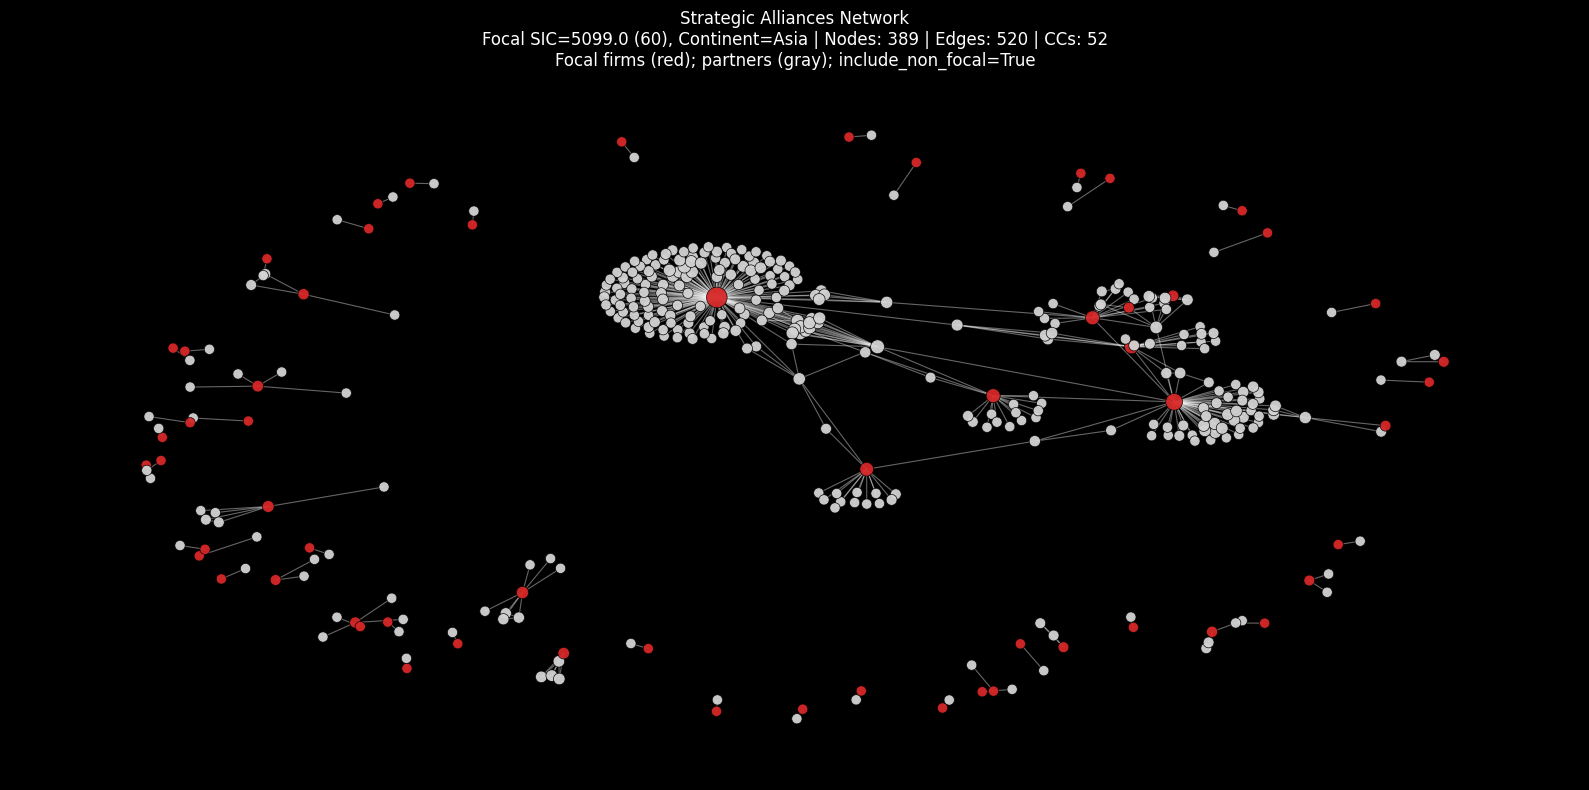

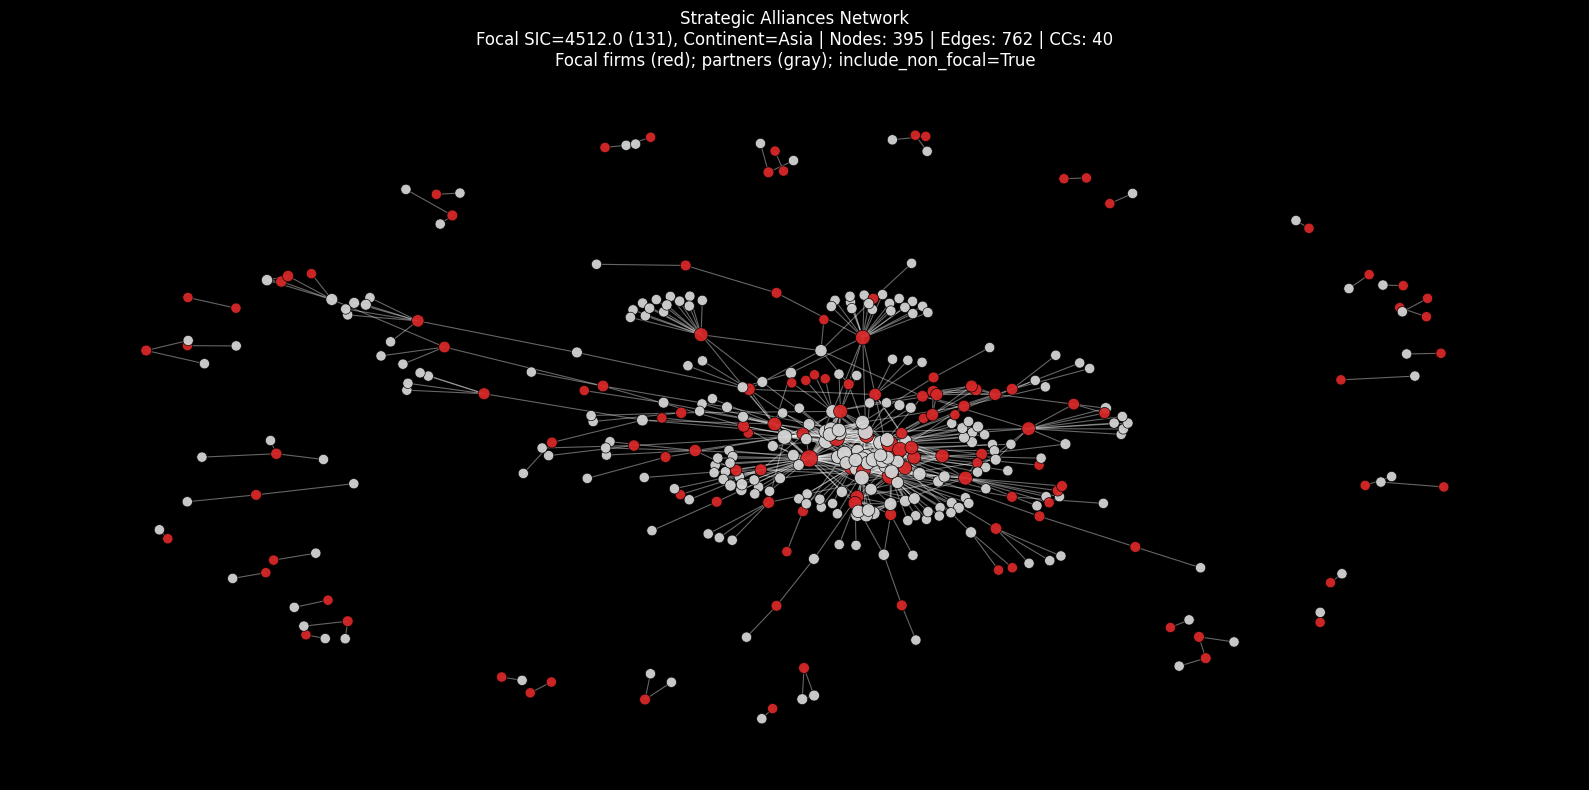

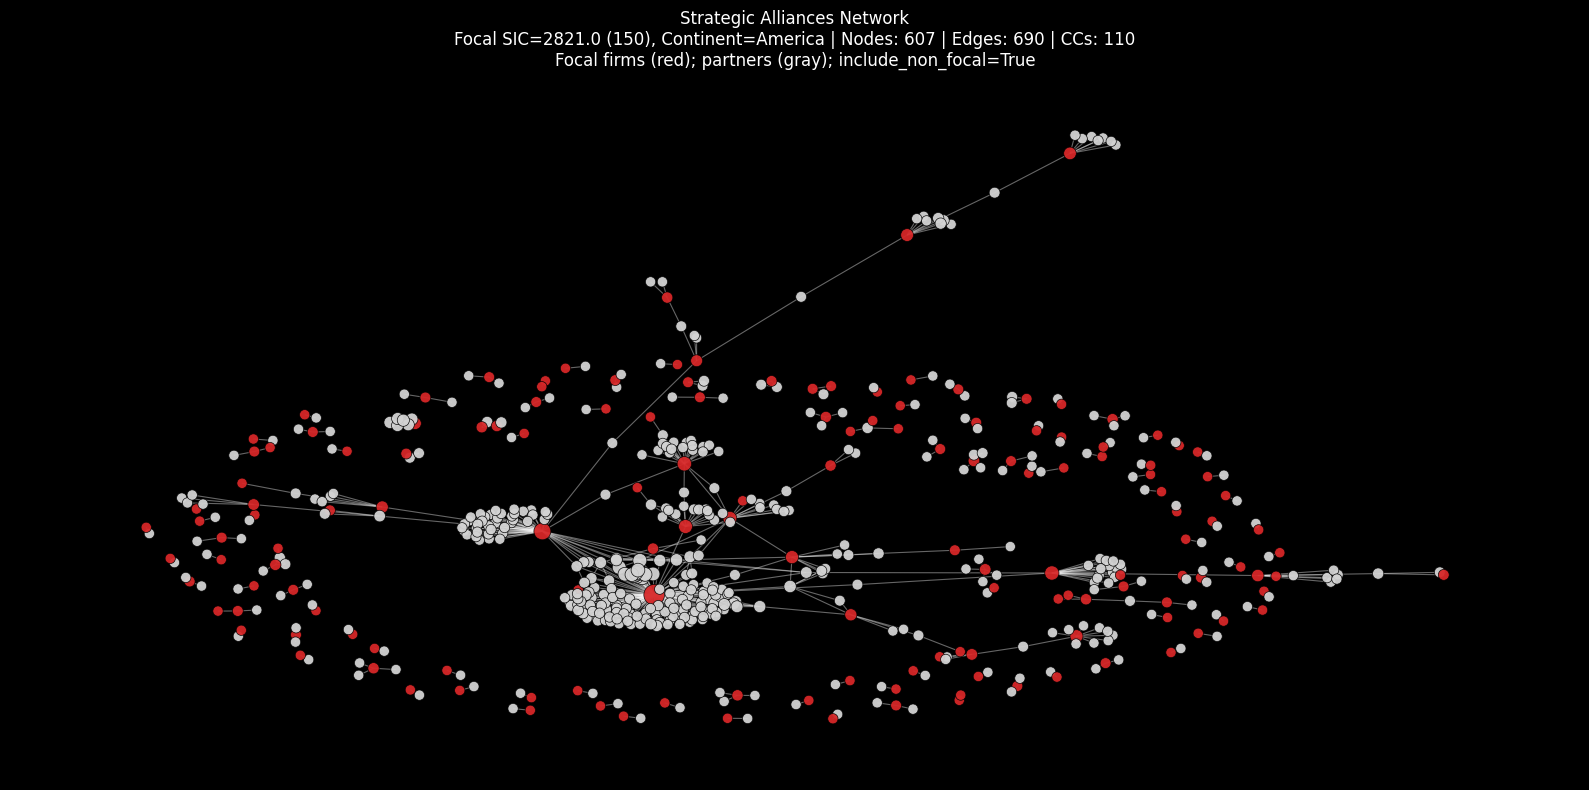

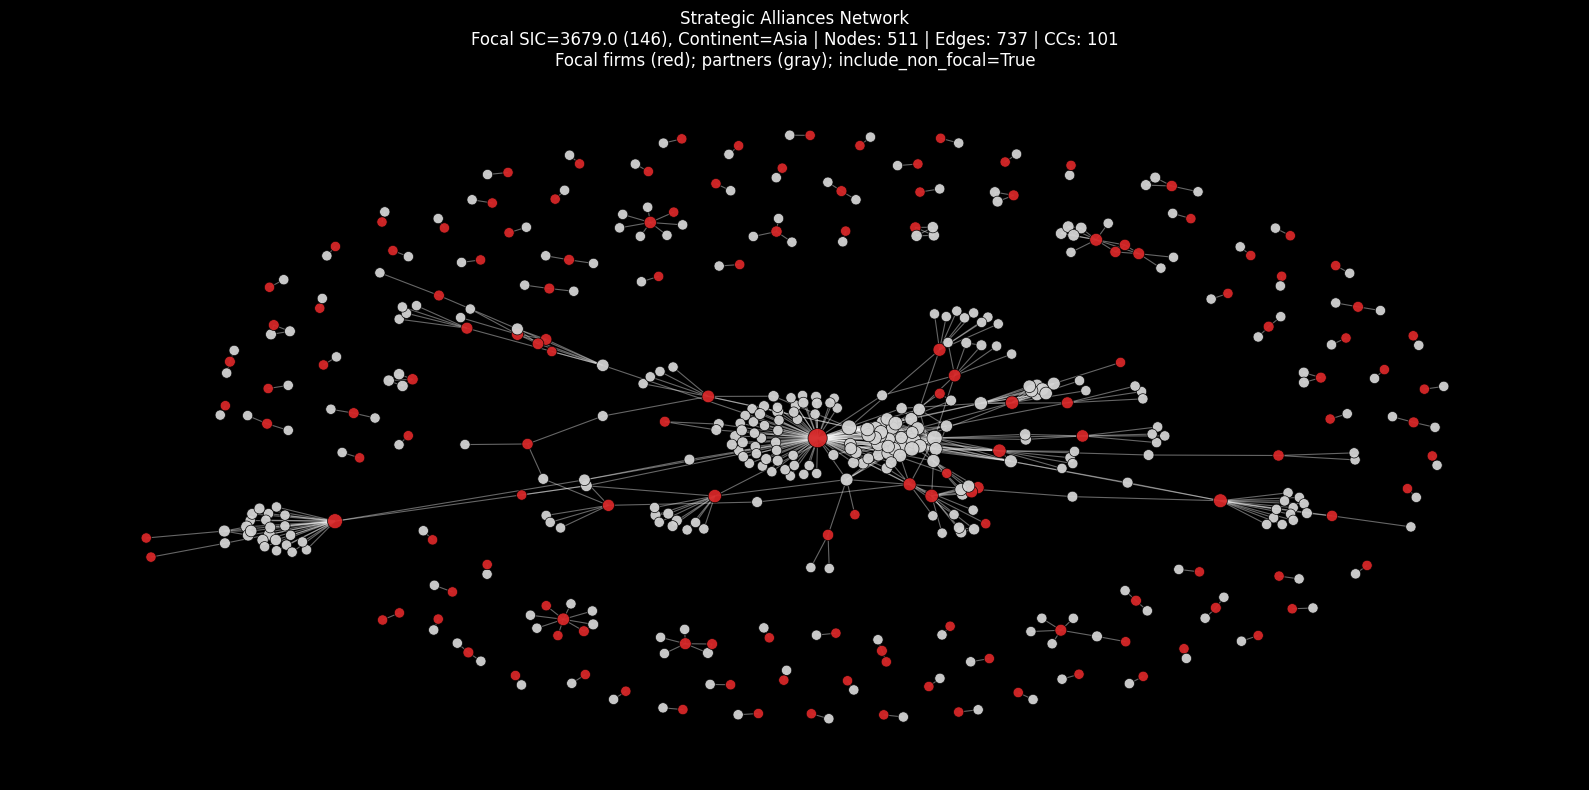

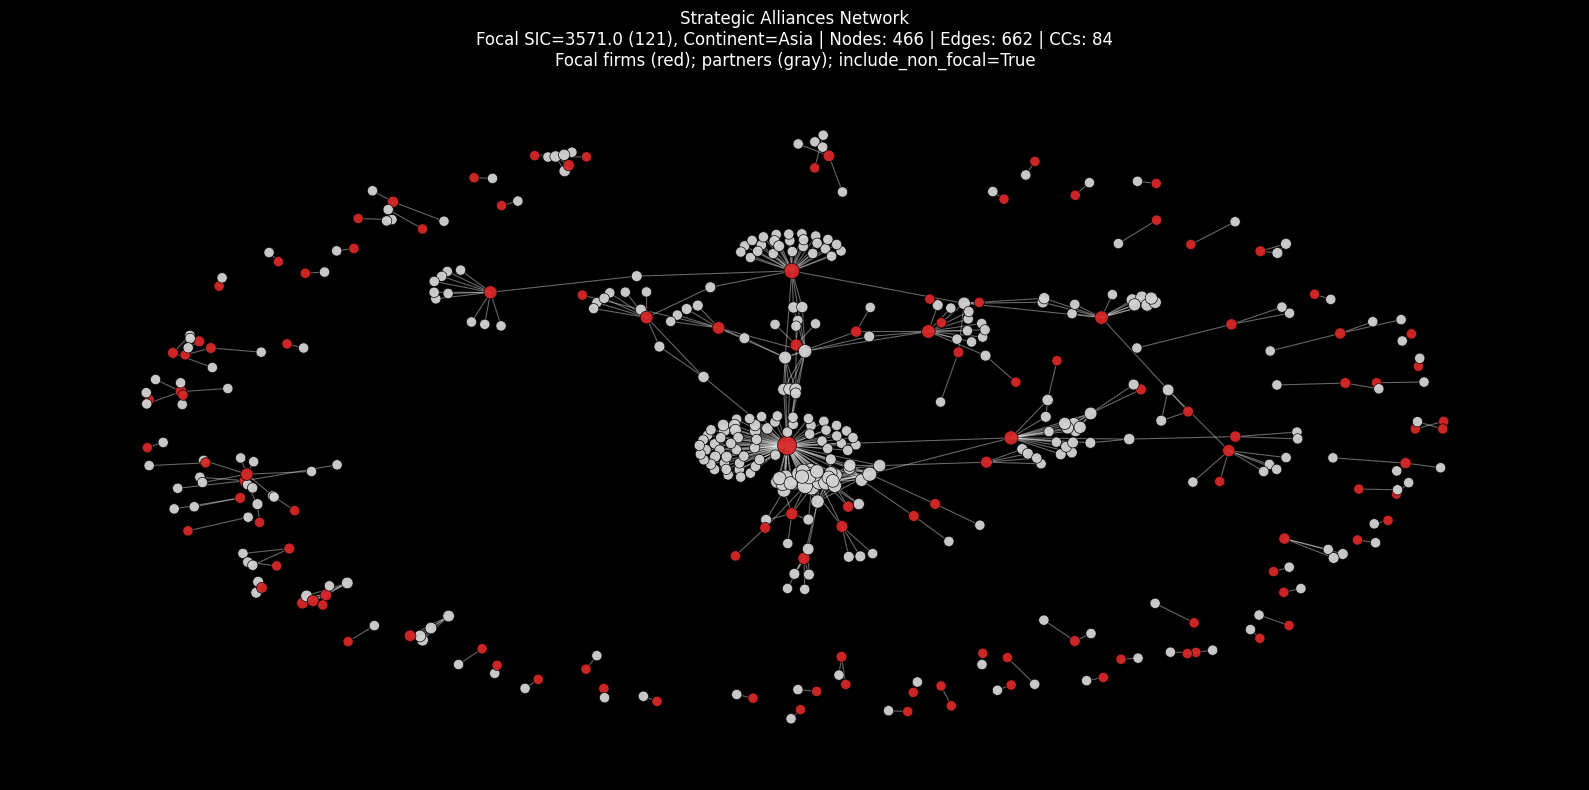

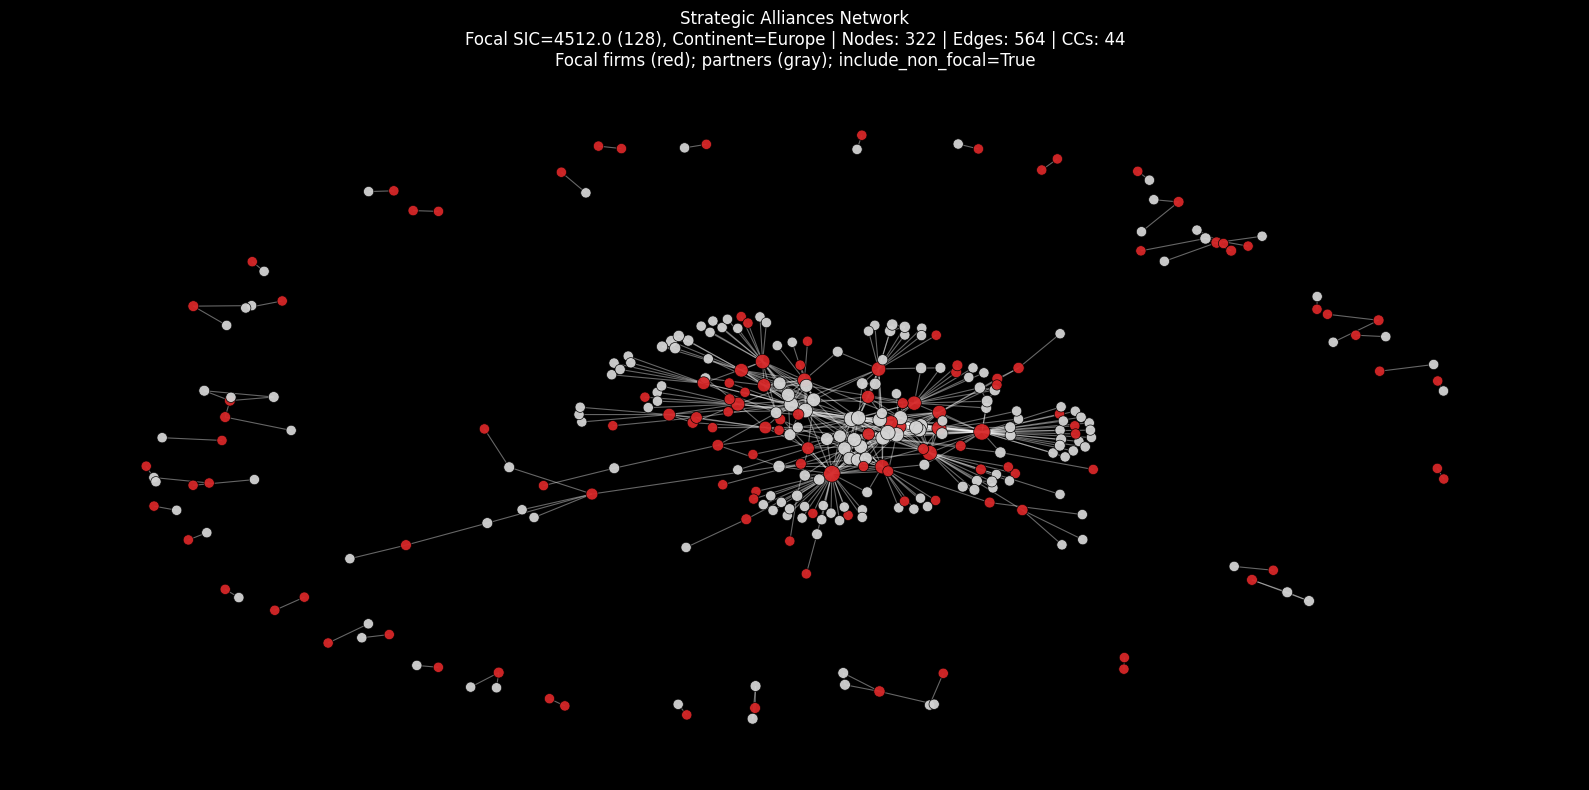

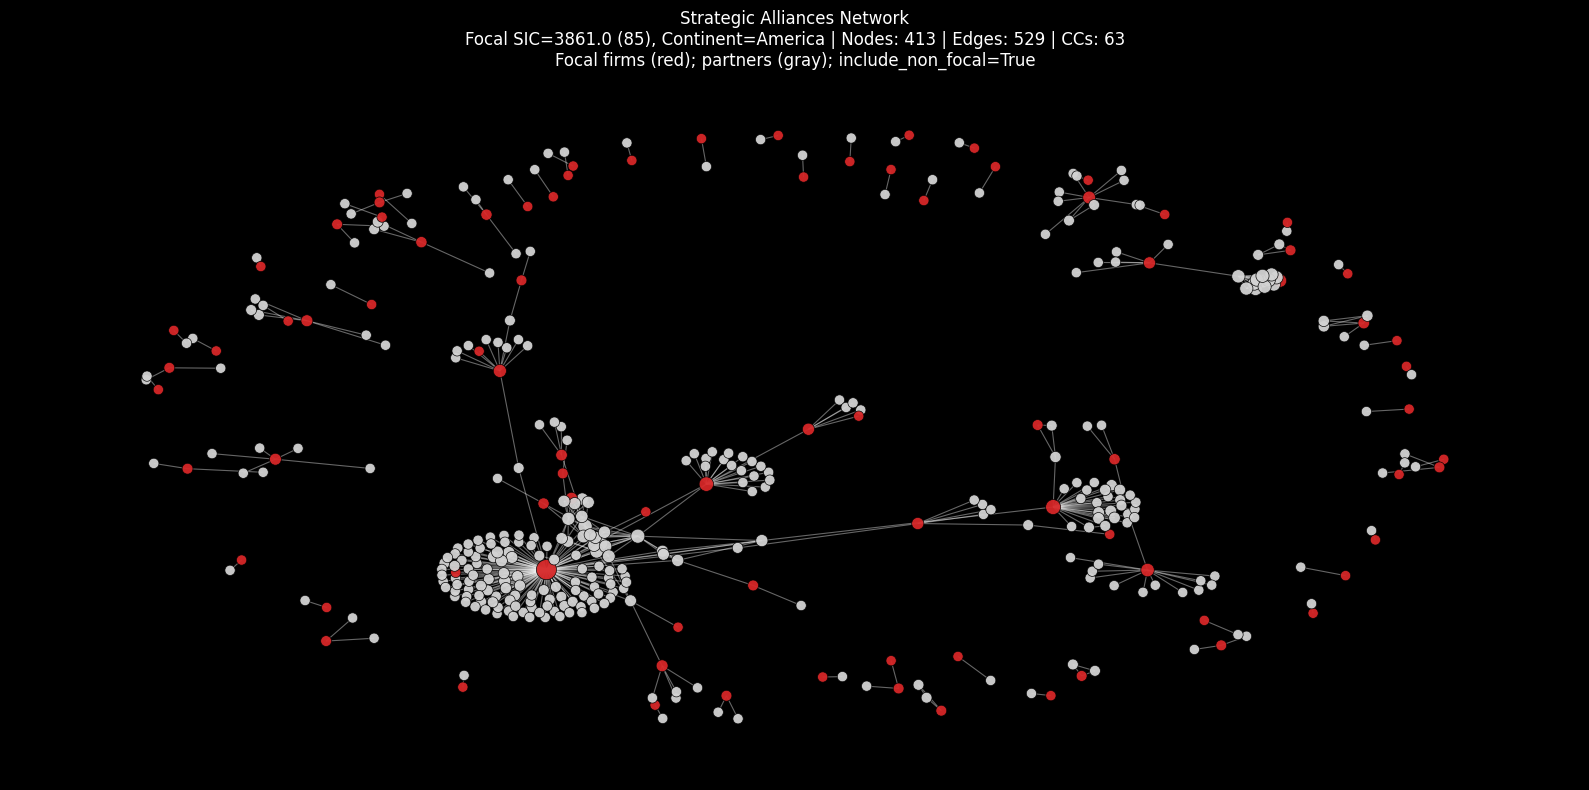

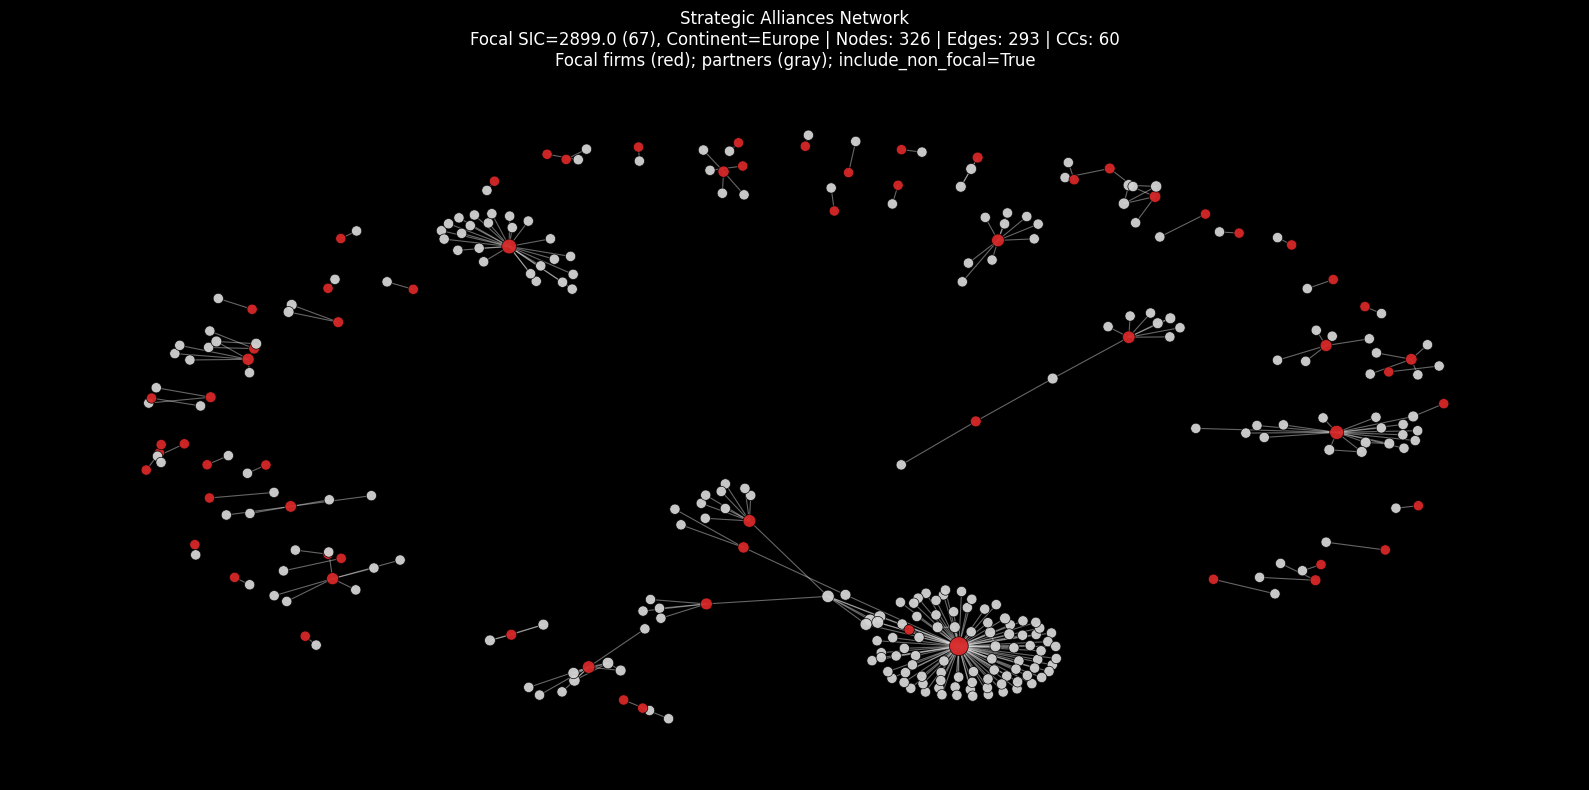

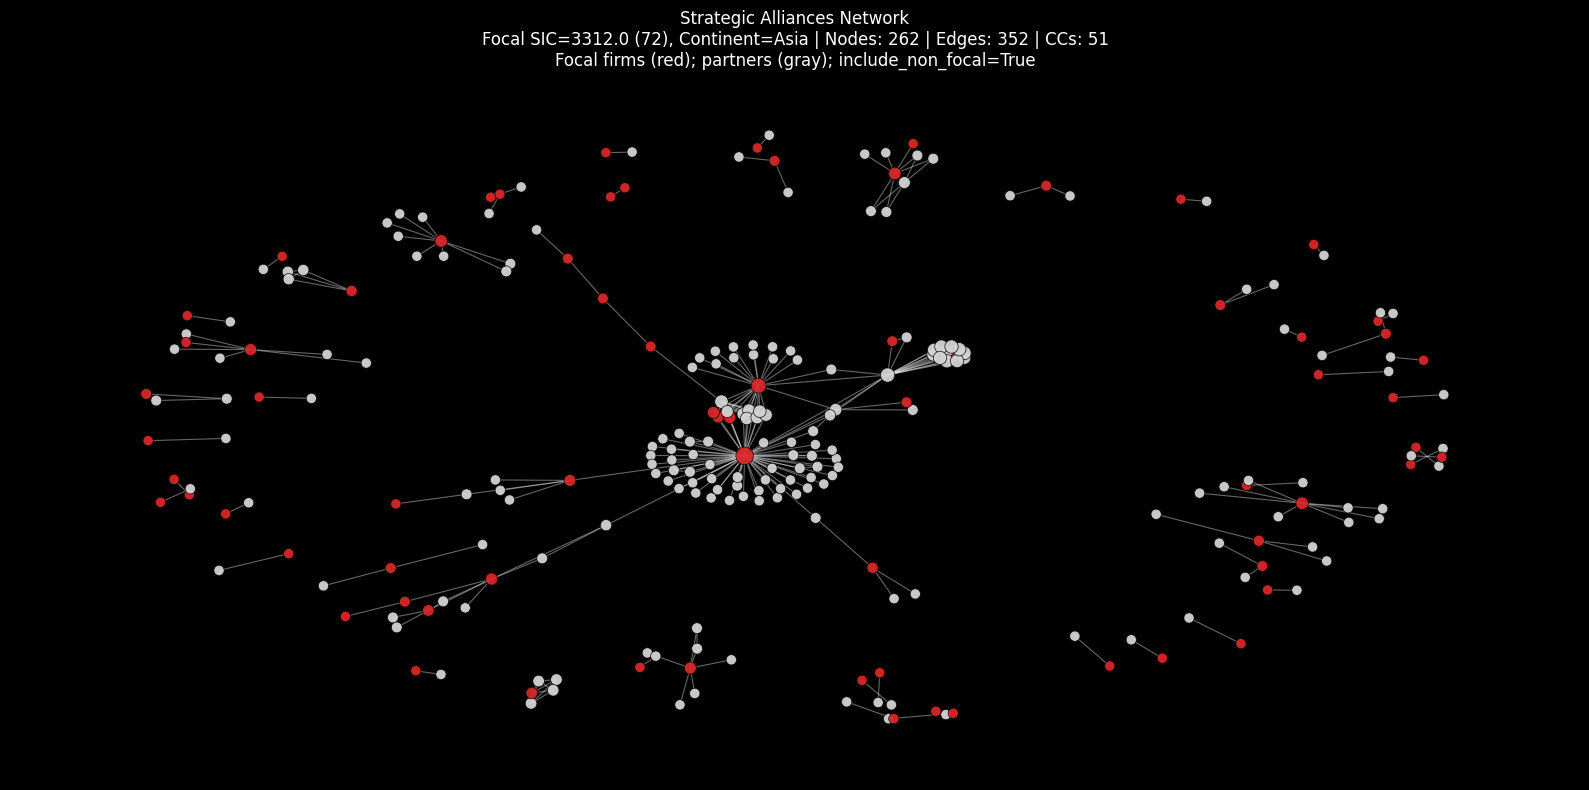

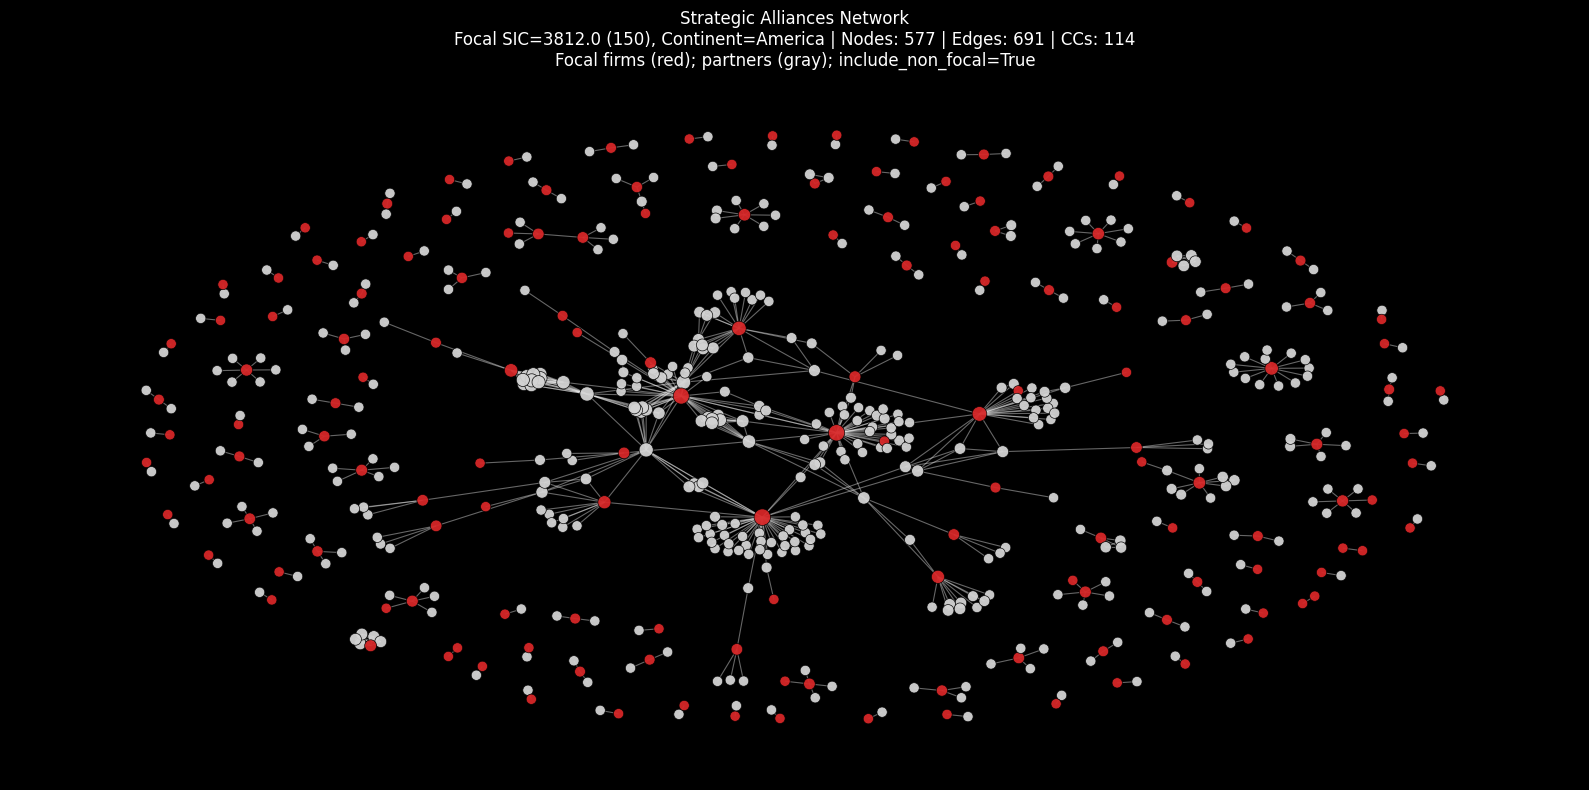

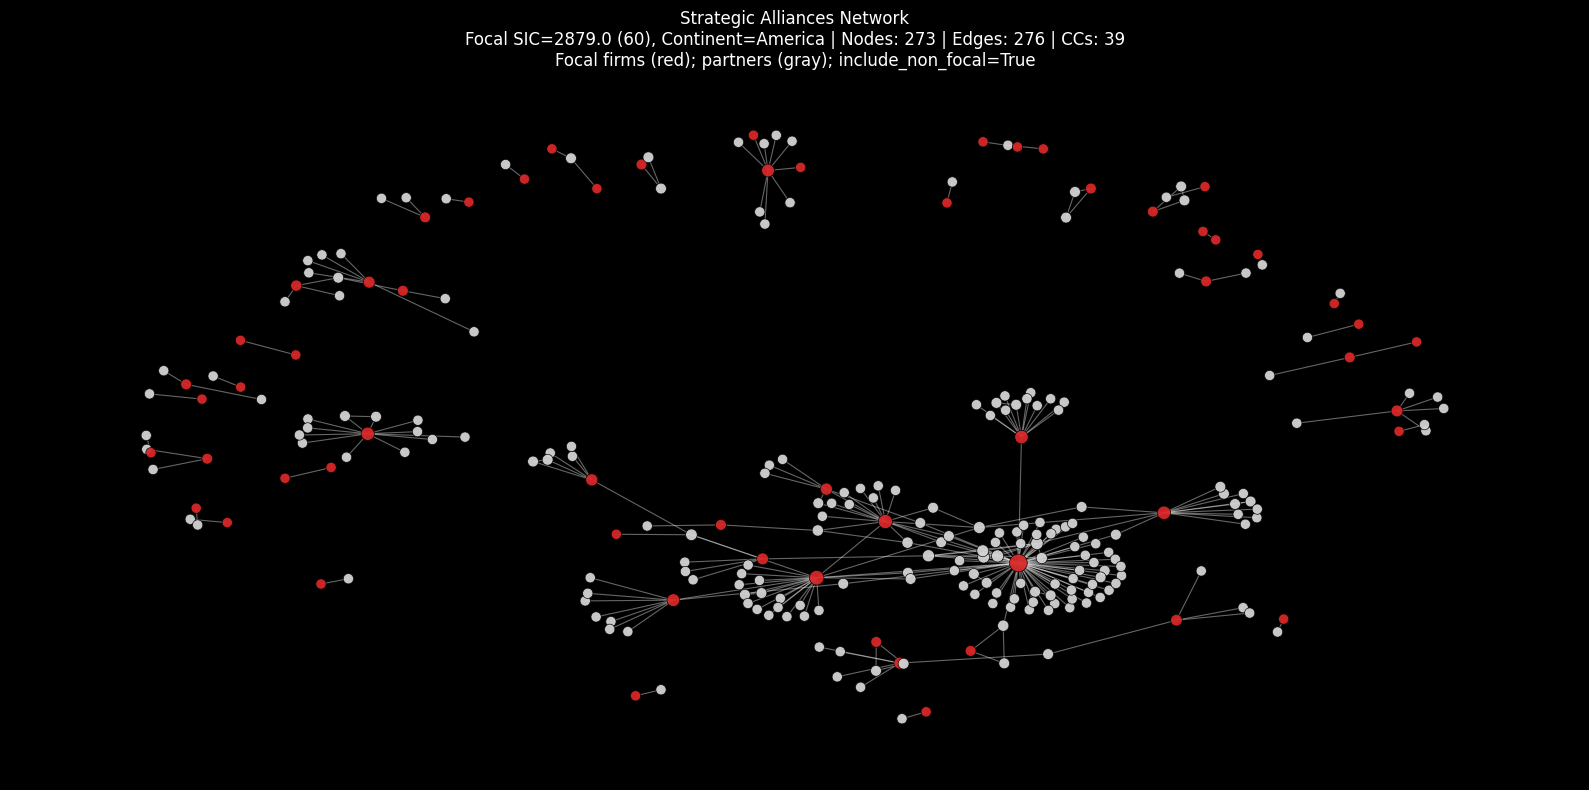

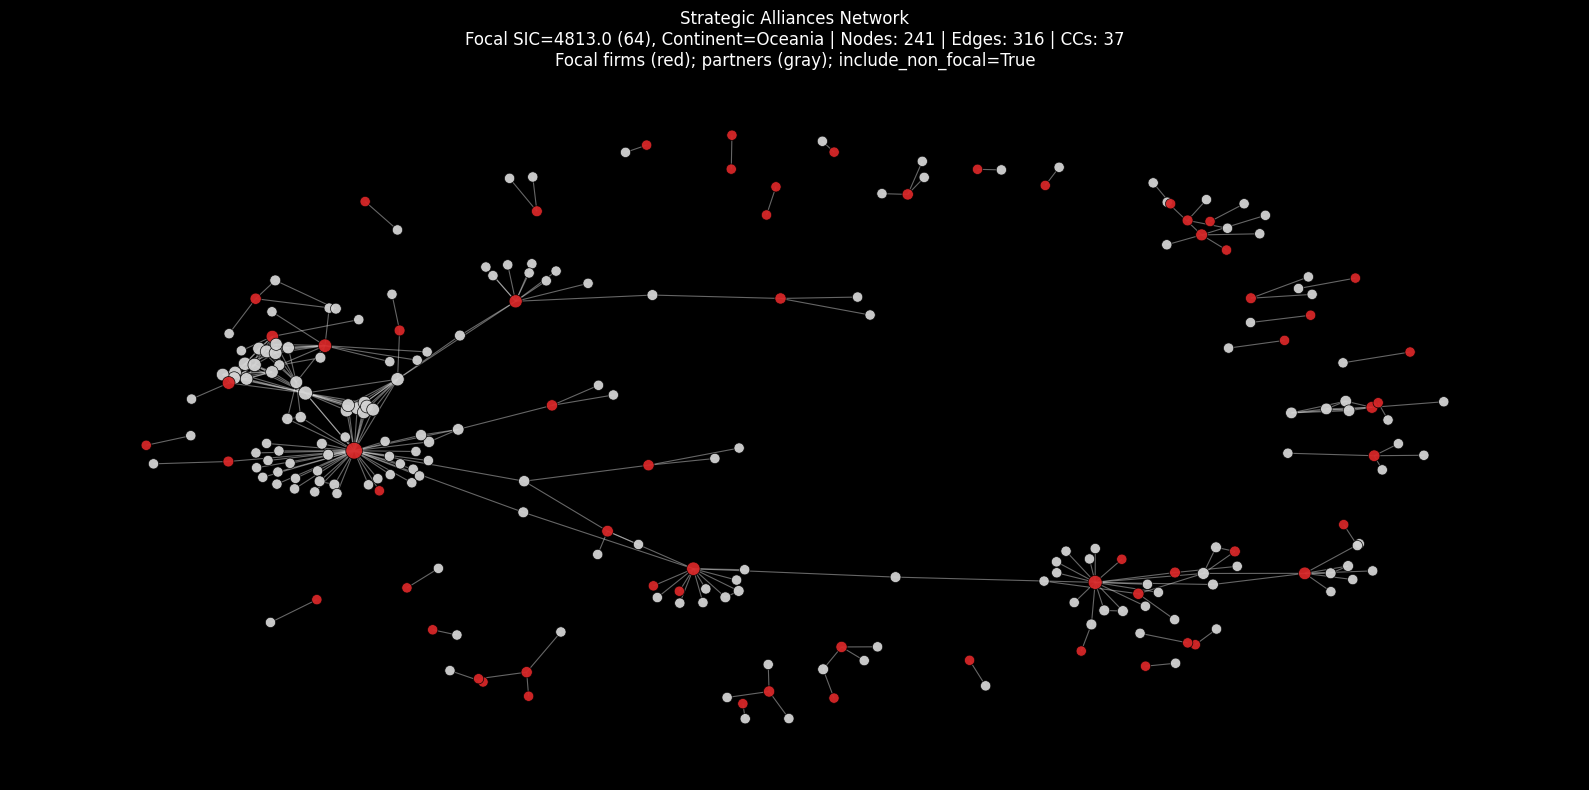

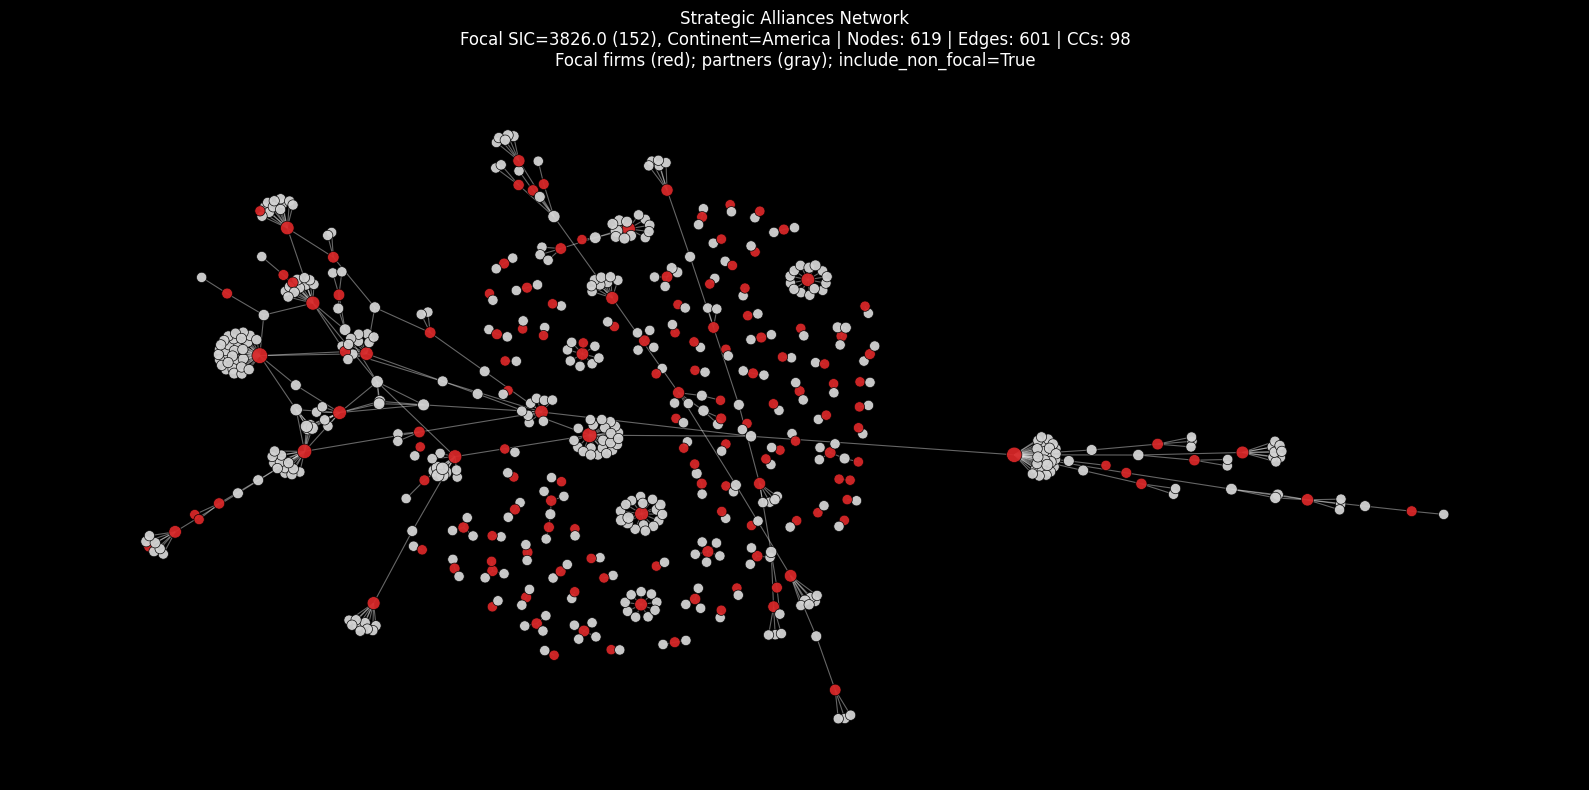

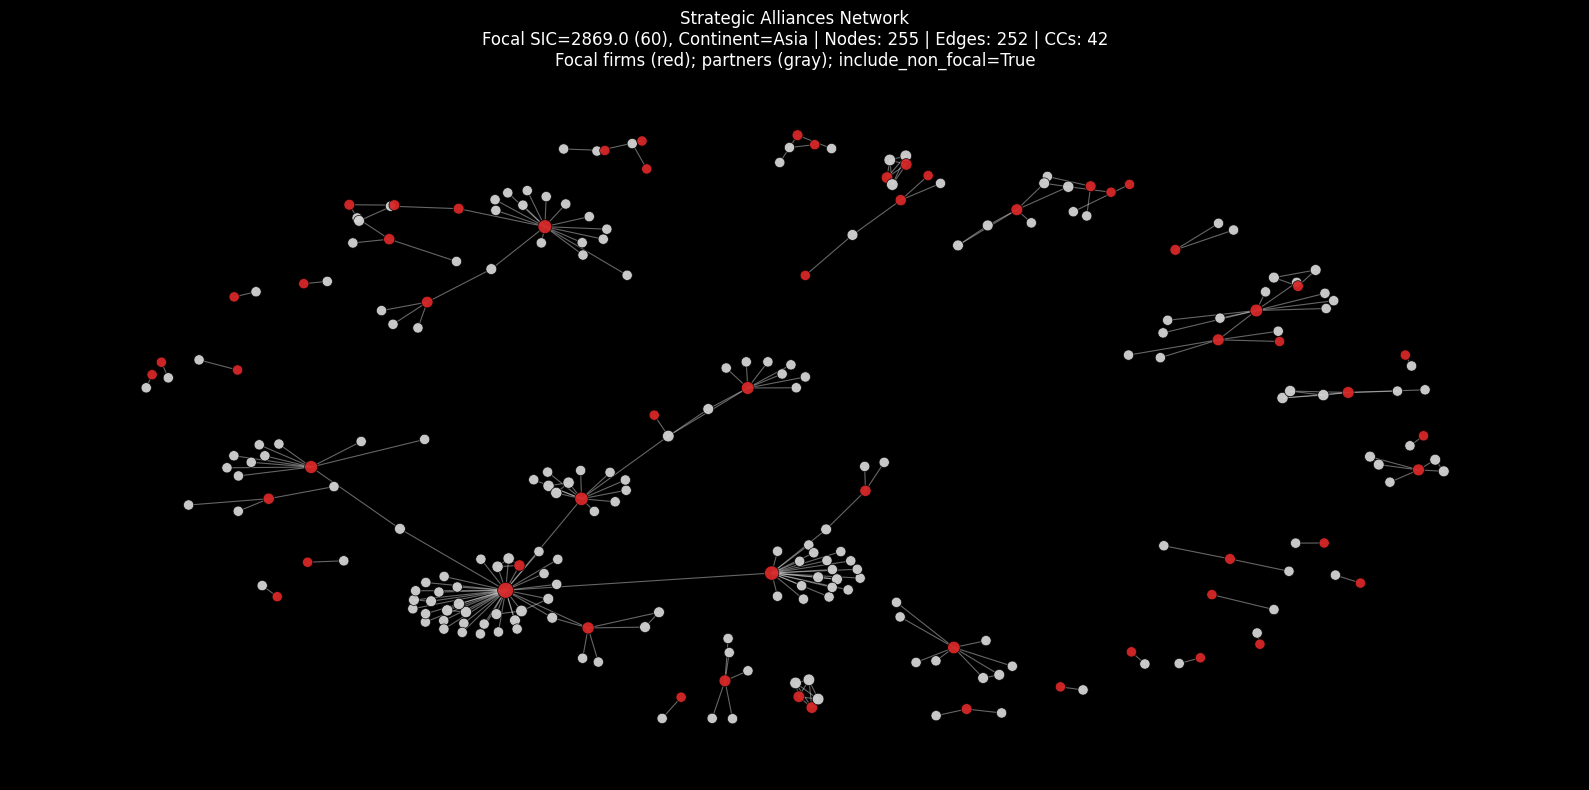

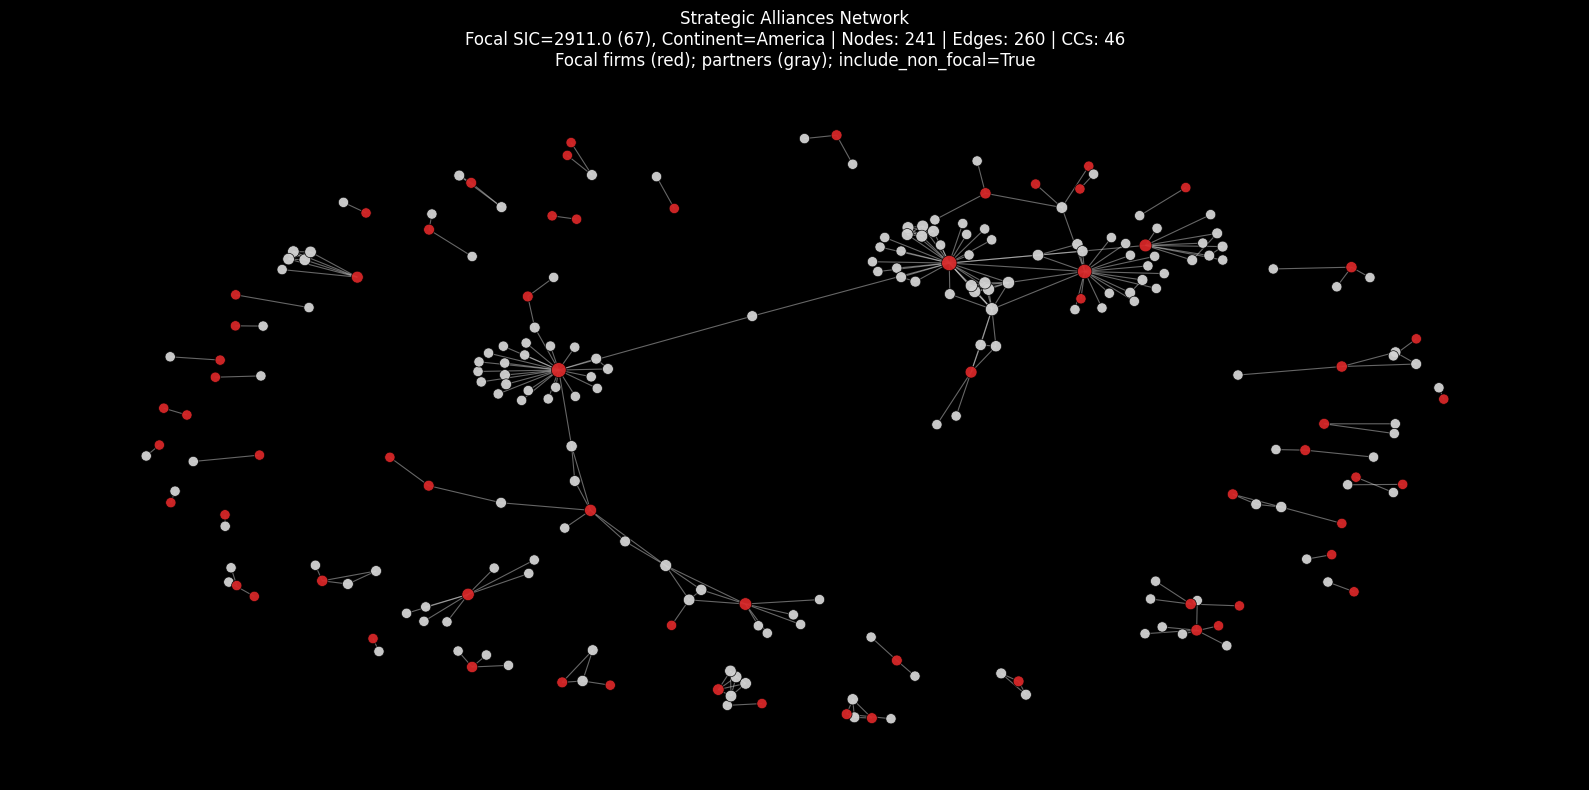

In [210]:
valid_list = []

for _, row in sic_region_stats_sorted.iterrows():
    if 60 <= row["n_focal_firms"] <= 155:
        G, focal_firms, n_components = plot_focal_industry_network(
            df=sdc_filt,
            sic_primary_code=row["sic_primary"],
            continent=row["continent"],
            min_degree=0,
            include_non_focal=True,
            plot=False,   # <--- important
        )

        if G is None:
            continue

        n_nodes = G.number_of_nodes()
        n_edges = G.number_of_edges()

        # average component size (nodes per CC)
        if n_components > 0:
            avg_comp_size = n_nodes / n_components
        else:
            avg_comp_size = float("inf")

        # apply your filters:
        if 5 <= avg_comp_size <= 10 and n_edges < 1000:
            valid_list.append(row)
            plot_focal_industry_network(
                df=sdc_filt,
                sic_primary_code=row["sic_primary"],
                continent=row["continent"],
                figsize=(16, 8),
                min_degree=0,
                include_non_focal=True,
                plot=True,
            )


In [211]:
pd.DataFrame(valid_list)

,sic_primary,continent,n_focal_firms,n_focal_deals,mean_degree,median_degree,max_degree,degree_std,degree_cv,n_cross_cont_deals,...,log_firms,log_deals,z_log_firms,z_log_deals,z_cross_cont_share,z_mean_degree,z_alliances_per_firm,z_network_mean_degree,z_degree_cv,interestingness_region
1551,3663.0,Europe,106,462,4.943396,1.0,189,23.579184,4.769835,333,...,4.672829,6.137727,1.979032,2.569205,0.848645,1.281726,1.239462,2.609044,6.661029,17.188143
1550,3663.0,Asia,139,449,3.467626,1.0,196,16.776698,4.838093,318,...,4.941642,6.109248,2.184882,2.550012,0.810029,0.701295,0.755021,1.044582,6.767230,14.813051
2174,5099.0,Asia,60,259,5.800000,1.0,145,19.556585,3.371825,189,...,4.110874,5.560682,1.548702,2.180321,0.876211,1.618634,1.221504,2.151296,4.485902,14.082570
1896,4512.0,Asia,131,405,5.381679,2.0,55,8.751408,1.626148,255,...,4.882802,6.006353,2.139823,2.480669,0.567923,1.454106,0.695506,4.130262,1.769850,13.238139
823,2821.0,America,150,477,3.593333,1.0,147,12.829184,3.570274,213,...,5.017280,6.169611,2.242803,2.590692,0.004046,0.750737,0.733460,1.483048,4.794664,12.599449
1582,3679.0,Asia,146,387,3.280822,1.0,102,8.884913,2.708136,248,...,4.990433,5.961005,2.222244,2.450108,0.602408,0.627824,0.506191,2.503787,3.453287,12.365849
1412,3571.0,Asia,121,329,3.371901,1.0,99,9.534741,2.827705,212,...,4.804021,5.799093,2.079495,2.340991,0.613341,0.663646,0.535527,2.431393,3.639320,12.303714
1897,4512.0,Europe,128,330,4.070312,1.0,47,7.342283,1.803862,232,...,4.859812,5.802118,2.122219,2.343030,0.793982,0.938336,0.475036,3.537056,2.046351,12.256010
1733,3861.0,America,85,322,4.223529,1.0,128,14.090778,3.336257,92,...,4.454347,5.777652,1.811724,2.326542,-0.491268,0.998597,0.994615,1.964578,4.430563,12.035351
921,2899.0,Europe,67,254,4.000000,1.0,93,11.609312,2.902328,153,...,4.219508,5.541264,1.631891,2.167234,0.483944,0.910682,0.995821,0.688041,3.755424,10.633037
